In [2]:
import pandas as pd
import numpy as np
import math

from saturation.simulation import *
from saturation.distributions import *
from saturation.geometry import *
from saturation.areal_density import *
from sklearn.metrics.pairwise import euclidean_distances

import matplotlib
import matplotlib.pyplot as plt

import plotly.express as px
import plotly.io as pio

In [3]:
def rotation_matrix(axis: List[float], theta: float):
    """
    Return the rotation matrix associated with counterclockwise rotation about
    the given axis by theta radians.
    """
    axis = np.asarray(axis)
    axis = axis / math.sqrt(np.dot(axis, axis))
    a = math.cos(theta / 2.0)
    b, c, d = -axis * math.sin(theta / 2.0)
    aa, bb, cc, dd = a * a, b * b, c * c, d * d
    bc, ad, ac, ab, bd, cd = b * c, a * d, a * c, a * b, b * d, c * d
    return np.array([[aa + bb - cc - dd, 2 * (bc + ad), 2 * (bd - ac)],
                     [2 * (bc - ad), aa + cc - bb - dd, 2 * (cd + ab)],
                     [2 * (bd + ac), 2 * (cd - ab), aa + dd - bb - cc]])

def rotate_points(p: List[float],
                  axis: List[float],
                  theta: float) -> np.array:
    return np.matmul(np.array(p), rotation_matrix(axis, theta))


def convert_lat_long_to_xyz(lat: pd.Series,
                            long: pd.Series,
                            planet_radius_km: float) -> pd.DataFrame:
    """
    Latitude and longitude are expressed in degrees.
    """
    lat = np.deg2rad(lat)
    long = np.deg2rad(long)

    result = pd.DataFrame({
           "x": planet_radius_km * np.cos(lat) * np.cos(long),
           "y": planet_radius_km * np.cos(lat) * np.sin(long),
           "z": planet_radius_km * np.sin(lat)
    })

    return result


def project_to_x_y(data: pd.DataFrame,
                   planet_radius_km: float) -> pd.DataFrame:
    """
    Diameters are assumed to be in meters.
    """
    # Calculate r_stat as min diameter / 2
    r_stat = data.d.min() / 2

    # Convert from lat/long to x, y, z
    xyz = convert_lat_long_to_xyz(data.latitude, data.longitude, planet_radius_km)
    data["x"] = xyz.x
    data["y"] = xyz.y
    data["z"] = xyz.z

    # Rotate points so that the centroid of (x, y) is at 0, 0
    coordinates = data[["x", "y", "z"]].values
    means = np.mean(coordinates, axis=0)
    theta = -(math.pi / 2 - np.arctan(means[2] / means[1]))
    p = rotate_points(coordinates, [1, 0, 0], theta)
    means = rotate_points([means], [1, 0, 0], theta)[0]
    
    theta = -np.arctan(means[2] / means[0])
    result = rotate_points(p, [0, 1, 0], theta)

    data["x"] = result[:, 1]
    data["y"] = result[:, 2]
    data["z"] = result[:, 0]

    return data

def calculate_log_mean_c2c_nn_dist(df_sub: pd.DataFrame,
                                   df_all: pd.DataFrame,
                                   planet_radius_km: float):
    """
    Diameters are assumed to be in meters.
    """
    # Label data inside/outside the study region
    data_outside = df_all.merge(df_sub, indicator=True, how='outer').query('_merge=="left_only"').drop('_merge', axis=1)
    data_outside["in_study_region"] = 0
    df_sub["in_study_region"] = 1
    data = pd.concat([data_outside, data_sub], axis=0)

    data = project_to_x_y(data, planet_radius_km)

    # Calculate all pairwise euclidean distances as a distance matrix
    distances = euclidean_distances(data[["x", "y"]], data[["x", "y"]])

    # Set diagonal to really large; we don't want these as zeros for the nearest neighbor distances
    for x in range(distances.shape[0]):
        distances[x, x] = 1e20

    # Calculate r_stat as min diameter / 2
    r_stat = data.d.min() / 2
    
    # Convert distances to units of a multiple of r-stat (meters)
    distances = distances * 1000 / r_stat
    
    # Mean log10 center-to-center nearest neighbor distance, in units of r_stat
    return np.log10(np.min(distances[data.index[data.in_study_region == 1]], axis=1)).mean()

In [4]:
def plot_circle(center: Location,
                radius: float,
                axes_subplot,
                fill: bool = False,
                color: str = 'black',
                lw: float = 1,
                antialiased: bool = True):
    """
    Plots the specified circle on the supplied subplot.
    """
    axes_subplot.add_patch(matplotlib.patches.Circle(center,
                                                     radius=radius,
                                                     color=color,
                                                     fill=fill,
                                                     lw=lw,
                                                     antialiased=antialiased))

def plot_terrain(data: pd.DataFrame):
    x_range = data.x.max() - data.x.min()
    y_range = data.y.max() - data.y.min()
    xy_range = max(x_range, y_range)
    
    figsize = 5
    fig, ax = plt.subplots(figsize=(figsize * x_range / xy_range, figsize * y_range / xy_range))

    # x, y are in km, radius is in m, let's make them consistent
    data = data.copy()
    data["r"] = data.d / 2 / 1000

    # ax.set_xlim([data.x.min() - 15, data.x.min() + xy_range + 15])
    # ax.set_ylim([data.y.min() - 15, data.y.min() + xy_range + 15])

    ax.set_xlim([data.x.min() - 15, data.x.max() + 15])
    ax.set_ylim([data.y.min() - 15, data.y.max() + 15])
    
    # Plot craters
    for idx, row in data.iterrows():
        plot_circle((row.x, row.y), row.r, ax)

    plt.show()

In [182]:
"""
reg1 = DEE, reg2 = DSP, reg3 = DICP, and reg4 = DDCP
Results:
Region 1 (DEE):
    log_mean_c2c_nn_dist: 0.814
    slope: -2.10 +/- 0.08
    5th percentile=5098
    95th percentile=249886

Region 2 (DSP):
    log_mean_c2c_nn_dist: 0.669
    slope: -2.66 +/- 0.05
    5th percentile=15609
    95th percentile=248371

Region 3 (DICP):
    log_mean_c2c_nn_dist: 0.934
    slope: -2.10 +/- 0.09
    5th percentile=2822
    95th percentile=147502

Region 4 (DDC):
    log_mean_c2c_nn_dist: 0.814
    slope: -2.10
    5th percentile=5098
    95th percentile=249886
"""

'\nreg1 = DEE, reg2 = DSP, reg3 = DICP, and reg4 = DDCP\nResults:\nRegion 1 (DEE):\n    log_mean_c2c_nn_dist: 0.814\n    slope: -2.10 +/- 0.08\n    5th percentile=5098\n    95th percentile=249886\n\nRegion 2 (DSP):\n    log_mean_c2c_nn_dist: 0.669\n    slope: -2.66 +/- 0.05\n    5th percentile=15609\n    95th percentile=248371\n\nRegion 3 (DICP):\n    log_mean_c2c_nn_dist: 0.934\n    slope: -2.10 +/- 0.09\n    5th percentile=2822\n    95th percentile=147502\n\nRegion 2 (DDC):\n    log_mean_c2c_nn_dist: 0.814\n    slope: -2.10\n    5th percentile=5098\n    95th percentile=249886\n'

In [6]:
dione_radius_km = 561.4

### Dione region 1: DEE

log mean nn dist = 0.8136


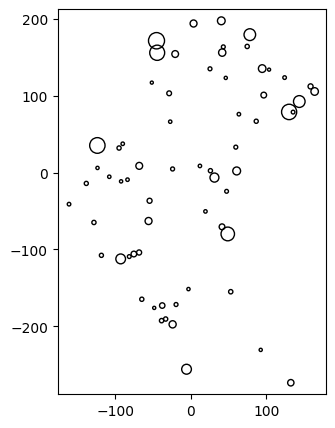

In [25]:
data_sub = pd.read_csv("data/Dione_reg1-sub.csv").rename({"Diameter:double": "d"}, axis=1)
data_all = pd.read_csv("data/Dione_reg1-all.csv").rename({"Diameter:double": "d"}, axis=1)

log_mean_nn_dist = calculate_log_mean_c2c_nn_dist(data_sub, data_all, dione_radius_km)
print(f"log mean nn dist = {log_mean_nn_dist:.4f}")

data = project_to_x_y(data_sub, dione_radius_km)
plot_terrain(data)

In [26]:
data_all.d.describe()

count      145.000000
mean      7403.295204
std       4130.081336
min       4005.566724
25%       4696.474094
50%       5589.926057
75%       8517.185632
max      26759.259730
Name: d, dtype: float64

In [27]:
# intensity:
np.log10(data_sub.shape[0] / 102449 / (data_sub.d.min() / 1000) ** 2)

-4.402922308048596

### Dione region 2: DSP

log mean nn dist = 0.6685


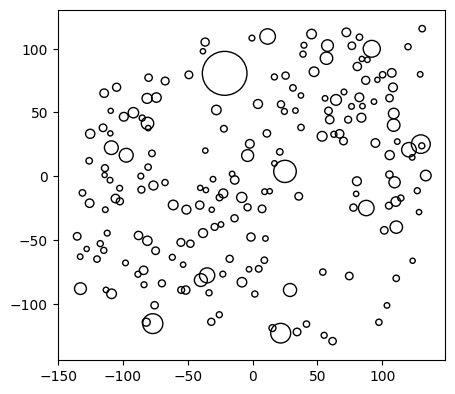

In [18]:
data_sub = pd.read_csv("data/Dione_reg2-sub.csv").rename({"Diameter:double": "d"}, axis=1)
data_all = pd.read_csv("data/Dione_reg2-all.csv").rename({"Diameter:double": "d"}, axis=1)

log_mean_nn_dist = calculate_log_mean_c2c_nn_dist(data_sub, data_all, dione_radius_km)
print(f"log mean nn dist = {log_mean_nn_dist:.4f}")

data = project_to_x_y(data_sub, dione_radius_km)
plot_terrain(data)

In [19]:
data_all.d.describe()

count      272.000000
mean      6552.208210
std       3679.090198
min       3995.469476
25%       4614.276675
50%       5586.862253
75%       7004.191361
max      34436.074990
Name: d, dtype: float64

In [24]:
# intensity:
np.log10(data_sub.shape[0] / 62647 / (data_sub.d.min() / 1000) ** 2)

-3.71673468421674

## Dione region 3: DICP

log mean nn dist = 0.9338


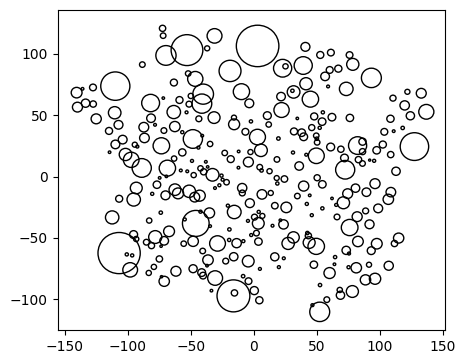

In [7]:
data_sub = pd.read_csv("data/Dione_reg3-sub.csv").rename({"Diameter:double": "d"}, axis=1)
# data_sub = data_sub[data_sub.d > 4000]
data_all = pd.read_csv("data/Dione_reg3-all.csv").rename({"Diameter:double": "d"}, axis=1)
# data_all = data_all[data_all.d > 4000]

log_mean_nn_dist = calculate_log_mean_c2c_nn_dist(data_sub, data_all, dione_radius_km)
print(f"log mean nn dist = {log_mean_nn_dist:.4f}")

data = project_to_x_y(data_sub, dione_radius_km)
plot_terrain(data)

<Axes: >

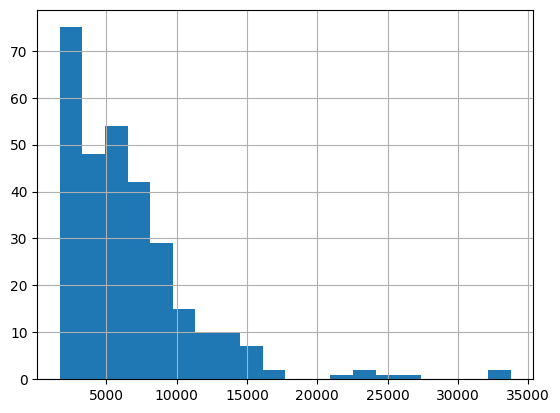

In [8]:
data.d.hist(bins=20)

In [9]:
data_all.d.sort_values()

68      1690.370196
32      1802.964460
300     1850.472160
395     1903.227261
312     1903.292520
           ...     
331    25174.274400
211    26073.754490
367    33520.159240
232    33761.534820
406    43259.096700
Name: d, Length: 432, dtype: float64

### Dione region 3: DICP, D_min > 4 km

log mean nn dist = 0.6304


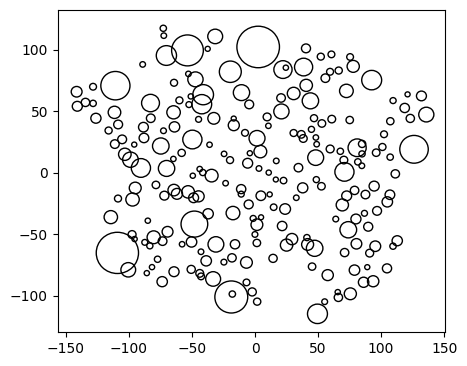

In [10]:
data_sub = pd.read_csv("data/Dione_reg3-sub.csv").rename({"Diameter:double": "d"}, axis=1)
data_sub = data_sub[data_sub.d > 4000]
data_all = pd.read_csv("data/Dione_reg3-all.csv").rename({"Diameter:double": "d"}, axis=1)
data_all = data_all[data_all.d > 4000]

log_mean_nn_dist = calculate_log_mean_c2c_nn_dist(data_sub, data_all, dione_radius_km)
print(f"log mean nn dist = {log_mean_nn_dist:.4f}")

data = project_to_x_y(data_sub, dione_radius_km)
plot_terrain(data)

<Axes: >

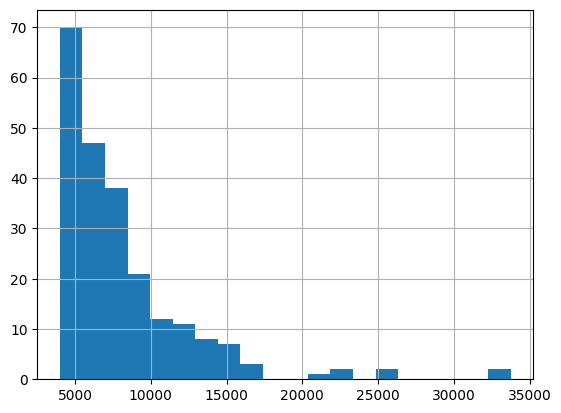

In [11]:
data.d.hist(bins=20)

## Dione region 4: DDCP

log mean nn dist = 0.5481


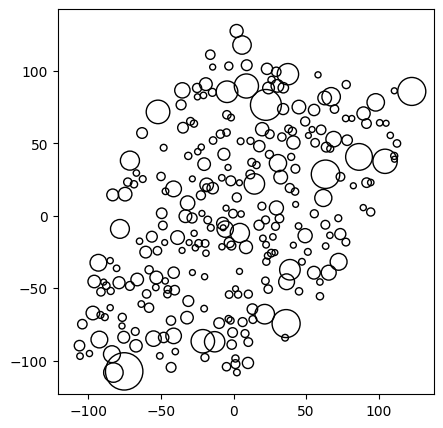

In [198]:
data_sub = pd.read_csv("data/Dione_reg4-sub.csv").rename({"Diameter:double": "d"}, axis=1)
data_all = pd.read_csv("data/Dione_reg4-all.csv").rename({"Diameter:double": "d"}, axis=1)

log_mean_nn_dist = calculate_log_mean_c2c_nn_dist(data_sub, data_all, dione_radius_km)
print(f"log mean nn dist = {log_mean_nn_dist:.4f}")

data = project_to_x_y(data_sub, dione_radius_km)
plot_terrain(data)

In [199]:
data_all.d.describe()

count      386.000000
mean      7402.719223
std       4832.579016
min       3995.000000
25%       4732.500000
50%       5858.500000
75%       8357.000000
max      59630.000000
Name: d, dtype: float64